In [1]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
all_data = pd.concat([train.drop(['target', 'id'], axis=1), test.drop('id', axis=1)])

In [3]:
target = pd.read_csv('train.csv').target

# fill NaN

In [4]:
all_data.replace(-1, np.NaN, inplace=True)

In [5]:
#all_data.shape[0]

In [6]:
#import missingno as msno
#msno.matrix(df=all_data, figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [7]:
#all_data.dtypes

In [8]:
#all_data.isna().sum()

In [9]:
#sns.countplot(all_data['ps_reg_03'])

In [10]:
all_data['ps_reg_03'].fillna(all_data['ps_reg_03'].mean(), inplace=True)

In [11]:
#sns.countplot(all_data.ps_car_11)

In [12]:
all_data.ps_car_11.fillna(all_data.ps_car_11.mode(), inplace=True)

In [13]:
#all_data.ps_car_12

In [14]:
all_data.ps_car_12.fillna(all_data.ps_car_12.mean(), inplace=True)

In [15]:
#all_data.ps_car_14

In [16]:
all_data.ps_car_14.fillna(all_data.ps_car_14.mean(), inplace=True)

In [17]:
#all_data.isna().sum()

In [18]:
all_data.fillna(-1, inplace=True)

In [19]:
#all_data.isna().sum()

# under sampling

In [20]:
from sklearn.utils import shuffle

In [21]:
len(train[train.target==0]), len(train[train.target==1])

(573518, 21694)

In [22]:
#train[train.target==0].index

In [23]:
###idx_0 = shuffle(train[train.target == 0].index, n_samples=len(train[train.target==1]))
###idx_0 = shuffle(train[train.target == 0].index, n_samples=len(train[train.target==1])*10)
idx_0 = shuffle(train[train.target == 0].index, n_samples=int(len(train[train.target==0])*0.7))

In [24]:
idx_1 = train[train.target == 1].index

In [25]:
#idx_0

In [26]:
#idx_1

In [27]:
#len(list(idx_0) + list(idx_1))

In [28]:
train = train.iloc[list(idx_0) + list(idx_1)].reset_index(drop=True)

In [29]:
#sns.countplot(train.target)

In [30]:
all_data = pd.concat([train.drop(['id', 'target'], axis=1), test.drop('id', axis=1)])

In [31]:
#all_data

# from categrical to dummy

In [32]:
col_cat =[]
for col in train.columns:
    if 'cat' in col:
        col_cat.append(col)

In [33]:
#col_cat

In [34]:
###all_data = pd.get_dummies(all_data, columns=col_cat)
all_data = pd.get_dummies(all_data, columns=col_cat)

# feature selection

In [35]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

In [36]:
#X_train

In [37]:
y_train = train.target

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)

In [39]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [40]:
#feature = X_train.columns
#importance = rf.feature_importances_
#feature_importance = pd.DataFrame({'feature':feature, 'importance':importance})

In [41]:
#feature_importance.sort_values('importance', ascending=False, inplace=True)

In [42]:
#plt.figure(figsize=(20, 80))
#sns.barplot(feature_importance.importance, feature_importance.feature)

In [43]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(rf, threshold='median', prefit=True)

In [44]:
#sfm.fit(X_train, y_train)

In [45]:
#sfm.transform(X_train).shape, sfm.transform(X_train).dtype

In [46]:
#X_train.shape, X_test.shape

In [47]:
select_feature = X_train.columns[sfm.get_support()]

In [48]:
#rf.fit(X_train[select_feature], y_train)

In [49]:
#feature = X_train[select_feature].columns
#importance = rf.feature_importances_
#feature_importances = pd.DataFrame({'feature':feature, 'importance':importance})

In [50]:
#feature_importances.sort_values('importance', ascending=False, inplace=True)

In [51]:
#plt.figure(figsize=(20, 40))
#sns.barplot(feature_importances.importance, feature_importances.feature)

In [52]:
X_train = X_train[select_feature]
X_test = X_test[select_feature]

# feature scaling

In [53]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()

In [54]:
#X_train = scaler.fit_transform(X_train)

In [55]:
#X_test = scaler.fit_transform(X_test)

# modeling

In [56]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

In [58]:
from sklearn.grid_search import GridSearchCV
params = {'max_depth': [-1, 5, 10], 'learning_rate': [0.01, 0.1], 'n_estimators': [100, 1000]}
model = GridSearchCV(lgb, params, cv=4)

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [59]:
model.fit(X_train.values, y_train)
#lgb.fit(X_train, y_train)

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-pac

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-pac

GridSearchCV(cv=4, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [-1, 5, 10], 'learning_rate': [0.01, 0.1], 'n_estimators': [100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [60]:
predict = model.predict_proba(X_test.values)
#predict_proba = lgb.predict_proba(X_test)

In [61]:
predict

array([[0.96403932, 0.03596068],
       [0.96848067, 0.03151933],
       [0.95833469, 0.04166531],
       ...,
       [0.95046575, 0.04953425],
       [0.96620374, 0.03379626],
       [0.96222504, 0.03777496]])

In [65]:
model.best_params_

{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100}

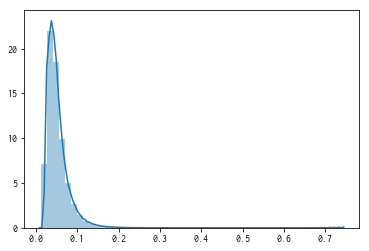

In [62]:
sns.distplot(predict[:, 1])

In [63]:
submit = pd.DataFrame({'id': test['id'], 'target': predict[:, 1]})

In [64]:
submit.to_csv('submit.csv', index=False)